Здесь представлен классический пайплайн с обучением бустингов, а так-же с перебором гиперпараметров

## **Импорты**

In [2]:
USING_COLAB = True

In [3]:
if USING_COLAB:
  %pip install catboost xgboost lightgbm -q

    # loading data
  !gdown 1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
  !gdown 12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
  !gdown 1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
  !gdown 1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
  !gdown 1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
To: /content/graph.csv
100% 5.75M/5.75M [00:00<00:00, 84.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
To: /content/submission.csv
100% 131k/131k [00:00<00:00, 67.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
To: /content/test2_X.csv
100% 40.0M/40.0M [00:00<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
To: /content/train_X.csv
100% 87.8M/87.8M [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo
To: /content/train_y.csv
100% 514k/514k [00:00<00:00, 82.1MB/s]


In [4]:
# Other tools
import pickle
import random
import os

from collections import Counter
from tqdm import tqdm
from copy import deepcopy

# Train
from sklearn.model_selection import KFold, StratifiedGroupKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import pandas as pd
import numpy as np

from datetime import datetime
from imblearn.over_sampling import SMOTE

# Model
import lightgbm as lgb
import xgboost as xgb

from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier

def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Session settings
pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'

def set_seed(seed=42):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(SEED)

SEED = 69
set_seed(SEED)

## **Пропроцессинг**

In [6]:
def preprocess_data(train, test, delete_corr_features=True, scale=True, init_features2drop=None):

    ts_features2drop = ['agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__8W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W', 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__8W', 'agg_cec_requests__g_contract__request_id__all__count__4W', 'agg_cec_requests__g_contract__request_id__all__count__5W', 'agg_cec_requests__g_contract__request_id__all__count__7W', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME', 'counteragent_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__request_id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__12M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__5M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__6M', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__7M', 'agg_ks2__g_contract__id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__12W', 'agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__8M', 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__4W', 'agg_workers__g_contract__fact_workers__all__mean__3W', 'agg_workers__g_contract__fact_workers__all__mean__26W', 'agg_workers__g_contract__fact_workers__all__mean__6W', 'agg_workers__g_contract__fact_workers__all__mean__12W', 'agg_workers__g_contract__fact_workers__all__mean__8W', 'agg_workers__g_contract__fact_workers__all__mean__5W', 'agg_Finance__g_contractor__Value__CostPrice_y__last__ALL_TIME', 'agg_Finance__g_contractor__Value__NetProfit_y__last__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__6W', 'agg_spass_applications__g_contract__appl_count_week__mean__26W', 'agg_spass_applications__g_contract__appl_count_week__max__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__12W', 'agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__4W', 'agg_spass_applications__g_contract__appl_count_week__mean__4W', 'agg_payments__g_contract__sum__all__countDistinct__2W', 'agg_scontrol__g_contractor__close_delay__defect_type_app__mean__ALL_TIME', 'agg_ks2__g_contract__id__all__count__2W', 'agg_ks2__g_contract__id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__4W', 'agg_ks2__g_contract__id__all__count__4W', 'agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W', 'agg_payments__g_contract__sum__all__countDistinct__12W', 'agg_payments__g_contract__sum__all__sum__8W', 'agg_materials__g_contract__order_id__countDistinct__12W', 'agg_materials__g_contract__material_id__countDistinct__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__8W', 'agg_payments__g_contract__sum__all__countDistinct__ALL_TIME', 'agg_payments__g_contract__date__advance__min__ALL_TIME', 'agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_ks2__g_contract__total_sum__all__sum__8W', 'agg_ks2__g_contract__id__all__count__12W', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__4M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_24M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_36M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_24M', 'agg_Finance__g_contractor__Value__CurrentAssets__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Balance__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Capital__last__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__1W', 'agg_sroomer__g_contractor__sroomer_id__count__12M', 'agg_sroomer__g_contractor__sroomer_id__count__6M', 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME', 'agg_sroomer__g_contractor__sroomer_id__count__3M', 'agg_ks2__g_contract__total_sum__all__sum__12W', 'agg_cec_requests__g_contract__created_dt__accepted__min__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__1W']
    constant_features_names = ['agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CompanySizeRevenue__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME', 'contract_date', 'contract_init_sum', 'agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedNetLiabilitiesSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedClaimsSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME']

    if delete_corr_features:
        train = train.drop(columns=ts_features2drop)
        test = test.drop(columns=ts_features2drop)

    # for now lets drop columns where num of nans is greater that  a half of df length
    isna_stat = train.isna().sum()[train.isna().sum() > 0]
    features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (3/5))]
    train.drop(columns=features2drop, inplace=True)
    test.drop(columns=features2drop, inplace=True)

    # other we`ll fill with median
    for col in isna_stat.index:
        if col not in features2drop:
            imp = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
            train[col] = imp.transform(train[col].values.reshape(-1, 1))
            test[col] = imp.transform(test[col].values.reshape(-1, 1))

    #translate to timestamp
    dates_columns = train.select_dtypes('object').columns

    new_dates_cols = []

    for date_col in dates_columns:
        train[f"{date_col}_day"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        train[f"{date_col}_month"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        test[f"{date_col}_day"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        test[f"{date_col}_month"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        train[date_col] = train[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
        test[date_col] = test[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())

        new_dates_cols.extend([f"{date_col}_day", f"{date_col}_month"])


    if init_features2drop is not None:
      train = train.drop(columns=[col for col in train.columns if col in init_features2drop])
      test = test.drop(columns=[col for col in train.columns if col in init_features2drop])

    return train, test, constant_features_names

## **Подгружаем -> предобрабатываем**

In [7]:
if not USING_COLAB:
  root_data_path = "data_partfinal"
else:
  root_data_path = "/content"

X_train = pd.read_csv(f"{root_data_path}/train_X.csv")
y_train_all = pd.read_csv(f"{root_data_path}/train_y.csv")

train = X_train.merge(y_train_all, on=["contract_id", "report_date"], how="left")
test = pd.read_csv(f"{root_data_path}/test2_X.csv")

y_train_all = train["default6"]
train_orig = deepcopy(train)

In [9]:
# adding contractor new graph features
graph_features = pd.read_csv("contractor_graph_features_v2.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

In [10]:
# adding contractor new graph features
graph_features = pd.read_csv("contractor_graph_features_v3.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

In [11]:
for_drop = ["project_id"]
cat_features = ["specialization_id"]

for_drop += ['agg_scontrol__g_contractor__close_delay__defect_type_tech_supervision__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__3M',
 'agg_sroomer__g_contractor__sroomer_id__count__6M',
 'agg_sroomer__g_contractor__sroomer_id__count__12M',
 'agg_spass_applications__g_specialization__appl_count_week__mean__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W',
 'counteragent_mean_agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxArrearsSum__last__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_arch_supervision__mean__ALL_TIME',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME',
 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME',
 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME',
 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'building_id',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME']


train, test, constant_features_names = preprocess_data(
    train.copy(),
    test.copy(),
    delete_corr_features=False,
    scale=False,
    init_features2drop=for_drop,
)

In [12]:
def gini_lgbm(y_pred, y_true):
    return 'gini', roc_auc_score(y_true.get_label(), y_pred) * 2 - 1, True

def gini_xgb(y_pred, y_true):
    y_true = y_true.get_label()
    return 'gini', 2 * roc_auc_score(y_true, y_pred) - 1

### Функции для кросс-валидаций стратифицированых по таргету и разделённых на группы по контрактам

In [15]:
import sklearn

def fit_cv_catboost(train, params):

  cat_models = []
  cat_ginis = []

  kf = StratifiedGroupKFold(n_splits=5, )
  for fold, (train_index, test_index) in enumerate(
            kf.split(
                X=train.drop("default6", axis=1),
                y=train["default6"],
                groups=train["contract_id"])
            ):

      print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

      X_train, X_valid, y_train, y_valid = train.iloc[train_index].drop("default6", axis=1), \
                                          train.iloc[test_index].drop("default6", axis=1), \
                                          train.iloc[train_index]["default6"], \
                                          train.iloc[test_index]["default6"]

      X_train.drop(columns=["contract_id"], inplace=True)
      X_valid.drop(columns=["contract_id"], inplace=True)

      cat_train_pool = Pool(
          data=X_train,
          label=y_train,
          cat_features=cat_features,
      )

      cat_valid_pool = Pool(
          data=X_valid,
          label=y_valid,
          cat_features=cat_features,
      )

      cat_clf = CatBoostClassifier(
        **params
      )

      cat_clf.fit(
          cat_train_pool,
          eval_set=[cat_train_pool, cat_valid_pool],
          early_stopping_rounds=50,
          verbose=10
      )

      cat_y_pred = cat_clf.predict_proba(
          X=cat_valid_pool
      )[:, 1]

      cat_models.append(cat_clf)
      cat_ginis.append(2 * roc_auc_score(y_valid, cat_y_pred) - 1)

      print(f"{'*' * 20}\nFOLD {fold} results:")
      print(f"catboost score: {cat_ginis[-1]}")
      print(f"{'-' * 20}")

  return cat_models, cat_ginis


def fit_cv_lgbm(train, params):

  lgbm_models = []
  lgbm_ginis = []

  kf = StratifiedGroupKFold(n_splits=5, )
  for fold, (train_index, test_index) in enumerate(
            kf.split(
                X=train.drop("default6", axis=1),
                y=train["default6"],
                groups=train["contract_id"])
            ):


      print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

      X_train, X_valid, y_train, y_valid = train.iloc[train_index].drop("default6", axis=1), \
                                          train.iloc[test_index].drop("default6", axis=1), \
                                          train.iloc[train_index]["default6"], \
                                          train.iloc[test_index]["default6"]

      X_train.drop(columns=["contract_id"], inplace=True)
      X_valid.drop(columns=["contract_id"], inplace=True)

      lgbm_train_data = lgb.Dataset(
          data=X_train,
          label=y_train
      )

      lgbm_test_data = lgb.Dataset(
          data=X_valid,
          label=y_valid,
          reference=lgbm_train_data
      )

      lgbm_clf = lgb.train(
          params,
          lgbm_train_data,
          num_boost_round=1000,
          valid_sets=[lgbm_test_data],
          valid_names=["validation"],
          feval=gini_lgbm,
          callbacks=[
              lgb.early_stopping(
                  stopping_rounds=50,
                  min_delta=0.01
              ),
              lgb.log_evaluation(period=0)
          ]
      )

      lgbm_y_pred = lgbm_clf.predict(
          X_valid,
          num_iteration=lgbm_clf.best_iteration,
          # raw_score=True
      )

      lgbm_models.append(lgbm_clf)
      lgbm_ginis.append(2 * roc_auc_score(y_valid, lgbm_y_pred) - 1)

      print(f"{'*' * 20}\nFOLD {fold} results:")
      print(f"lgbm score: {lgbm_ginis[-1]}")
      print(f"{'-' * 20}")

  return lgbm_models, lgbm_ginis

def fit_cv_xgboost(train, params):

  xgb_models = []
  xgb_ginis = []

  kf = StratifiedGroupKFold(n_splits=5, )
  for fold, (train_index, test_index) in enumerate(
            kf.split(
                X=train.drop("default6", axis=1),
                y=train["default6"],
                groups=train["contract_id"])
            ):


      print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

      X_train, X_valid, y_train, y_valid = train.iloc[train_index].drop("default6", axis=1), \
                                          train.iloc[test_index].drop("default6", axis=1), \
                                          train.iloc[train_index]["default6"], \
                                          train.iloc[test_index]["default6"]

      X_train.drop(columns=["contract_id"], inplace=True)
      X_valid.drop(columns=["contract_id"], inplace=True)



      xgb_train_data = xgb.DMatrix(
          data=X_train,
          label=y_train
      )

      xgb_test_data = xgb.DMatrix(
          data=X_valid,
          label=y_valid
      )

      evals = [(xgb_test_data, 'eval'), (xgb_train_data, 'train')]
      xgb_clf = xgb.train(
          params,
          dtrain=xgb_train_data,
          num_boost_round=1000,
          feval=gini_xgb,
          evals=evals,
          early_stopping_rounds=50
      )
      xgb_y_pred = xgb_clf.predict(xgb_test_data)

      xgb_models.append(xgb_clf)
      xgb_ginis.append(roc_auc_score(y_valid, xgb_y_pred) * 2 - 1)

      print(f"{'*' * 20}\nFOLD {fold} results:")
      print(f"xgb score: {xgb_ginis[-1]}")
      print(f"{'-' * 20}")

  return xgb_models, xgb_ginis

### Прогоняем всё это

In [ ]:
cb_params = dict(
  iterations=1000,
  max_depth=6,
  border_count=255,
  eval_metric="NormalizedGini",
  early_stopping_rounds=50,
  use_best_model=True,
  auto_class_weights="Balanced",
  # scale_pos_weight=7.5,
  boosting_type="Ordered",
  # embedding_features=['contract_embeddings'],
  verbose=25,
  colsample_bylevel=0.05,
  subsample=0.95,
  # l2_leaf_reg=9,
  # min_data_in_leaf=200,
  random_strength=1,
)

cat_models, cat_scores = fit_cv_catboost(train, cb_params)

In [ ]:
lgbm_params = {
  'objective': 'binary',
  # 'metric': 'auc',
  'boosting_type': 'gbdt',
  'num_leaves': 2,
  'learning_rate': 0.05,
  'feature_fraction': 0.9,
  # 'data_sample_strategy': 'goss',
  'num_iteratins' : 700,
  'max_depth': 2,
}

lgb_models, lgb_scores = fit_cv_lgbm(train, lgbm_params)

In [ ]:
xgb_params = {
  'objective': 'binary:logistic',
  # 'eval_metric': gini_xgb,
  'learning_rate': 0.15,
  'max_depth': 6,
  'subsample': 0.9,
  'colsample_bytree': 0.05,
  'seed': SEED,
  'verbosity':0
}

xgb_models, xgb_scores = fit_cv_xgboost(train, xgb_params)

## Оптимизация гиперпараметров

## **Inference**

In [20]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00


In [34]:
import optuna
def tune_hyperparams(
    model,
    train,#cat_cols
    n_trials,
    cat_cols=None,
    save_weights=False,
    fixed_params=None
):

    if fixed_params is None:
        fixed_params = {}


    if model not in ["catboost", "xgboost", "lgbm"]:
        print(f"Incorrect model {model}, valid are ['catboost', 'xgboost', 'lgbm']")


    if model == "catboost":

        base_params =  {
            "n_estimators": 300,
            "verbose": 50,
            "early_stopping_rounds": 50,
            "loss_function": "Logloss",
            "eval_metric": "NormalizedGini",
            "auto_class_weights" : "Balanced",
            "use_best_model": True,
        }


        for i in base_params.keys():
            if i not in fixed_params:
                fixed_params[i]=base_params[i]

        def objective(
            trial, init_params=fixed_params
        ):
            params = {
                "learning_rate": trial.suggest_float(
                    "learning_rate", 0.005, 0.2, log=True
                ),
                "subsample": trial.suggest_float(
                    "subsample", 0.4, 1, log=True
                ),
                "depth": trial.suggest_int("depth", 3, 10),
                "l2_leaf_reg": trial.suggest_float(
                    "l2_leaf_reg", 1e-1, 100.0, log=True
                ),
                "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 100, 500),
                "random_strength": trial.suggest_float(
                    "random_strength", 1e-3, 10.0, log=True
                )

            }

            for i in init_params.keys():
                params[i]=init_params[i]

            _, scores = fit_cv_catboost(train, params)

            return np.mean(scores) - np.std(scores)


    if model == 'lgbm':

      base_params = {
        'objective': 'binary',
        'learning_rate': 0.05,
      }

      for i in base_params.keys():
          if i not in fixed_params:
              fixed_params[i]=base_params[i]

      def objective(
          trial, init_params=fixed_params
      ):
          params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
              'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
              'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
              'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
              'gpu_use_dp': True,
          }

          for i in init_params.keys():
              params[i]=init_params[i]

          _, scores = fit_cv_lgbm(train, params)

          return np.mean(scores) - np.std(scores)

    if model == 'xgboost':

      base_params = {
        'objective': 'binary:logistic',
        'seed': SEED,
        'verbosity':0
      }

      for i in base_params.keys():
          if i not in fixed_params:
              fixed_params[i]=base_params[i]

      def objective(
          trial, init_params=fixed_params
      ):
          params = {
              'learning_rate': trial.suggest_float('learning_rate', 0.00001, 1.0, log=True),
              'max_depth': trial.suggest_int('max_depth', 1, 50),
              'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
              'subsample': trial.suggest_float('subsample', 0.1, 1.0),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
              'gamma': trial.suggest_float('gamma', 0, 20),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 100.0),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 100.0),
              'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
              'max_delta_step': trial.suggest_float('max_delta_step', 0.0, 10.0),
              'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
              'max_bin': trial.suggest_int('max_bin', 256, 512),
          }

          for i in init_params.keys():
              params[i]=init_params[i]

          _, scores = fit_cv_xgboost(train, params)

          return np.mean(scores) - np.std(scores)



    study = optuna.create_study(direction="maximize")

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    print('='*30)
    trial = study.best_trial

    print("GINI: {}".format(trial.value))
    print('='*30)
    print("  Params: {")

    params = trial.params

    for i in fixed_params.keys():
            if i not in params:
                params[i]=fixed_params[i]

    for key, value in params.items():
        if isinstance(value, str):
            print("    '{}': '{}',".format(key, value))
        else:
            print("    '{}': {},".format(key, value))
    print('}')
    return params, trial.value

In [ ]:
tune_hyperparams(
    model='catboost',
    train=train,
    n_trials=1,
    cat_cols=cat_features,
    save_weights=False,
    fixed_params=None
)

## формируем сабмит

In [ ]:
test = test.drop(["contract_id"] + ['contractor_id', 'report_date_month', 'contract_date_month', 'contract_date', 'report_date'], axis=1)
cat_test_pool = Pool(test, cat_features=cat_features,)#embedding_features=['contract_embeddings'])

In [ ]:
test_preds = {"cat" : [], "xgb" : [], "lgbm" : []}

for fold, (cat_model, lgbm_model, xgb_model) in enumerate(
      zip(cat_models, lgb_models, xgb_models)
    ):

  #getting preds
  cat_p = cat_model.predict_proba(cat_test_pool)[:, 1]
  lgbm_p = lgbm_model.predict(test, num_iteration=lgbm_model.best_iteration)
  xgb_p = xgb_model.predict(xgb.DMatrix(test))

  test_preds["cat"].append(cat_p)
  test_preds["lgbm"].append(lgbm_p)
  test_preds["xgb"].append(xgb_p)

In [ ]:
cat_final_p =  sum([w * p for w, p in zip(cat_scores, test_preds["cat"])]) / sum(cat_scores)
xgb_final_p =  sum([w * p for w, p in zip(xgb_scores, test_preds["xgb"])]) / sum(xgb_scores)
lgbm_final_p =  sum([w * p for w, p in zip(lgb_scores, test_preds["lgbm"])]) / sum(lgb_scores)

In [ ]:
cat_final_w = np.mean(cat_scores) - np.std(cat_scores)
lgbm_final_w = np.mean(lgb_scores) - np.std(lgb_scores)
xgb_final_w = np.mean(xgb_scores) - np.std(xgb_scores)

test_final_preds = (cat_final_p * cat_final_w + xgb_final_p * xgb_final_w + lgbm_final_p * lgbm_final_w) / (cat_final_w + xgb_final_w + lgbm_final_w)
# test_final_preds = (cat_final_p * cat_final_w + xgb_final_p * xgb_final_w) / (cat_final_w + xgb_final_w)
# test_final_preds = (cat_final_p * cat_final_w) / (cat_final_w)

<Axes: ylabel='Count'>

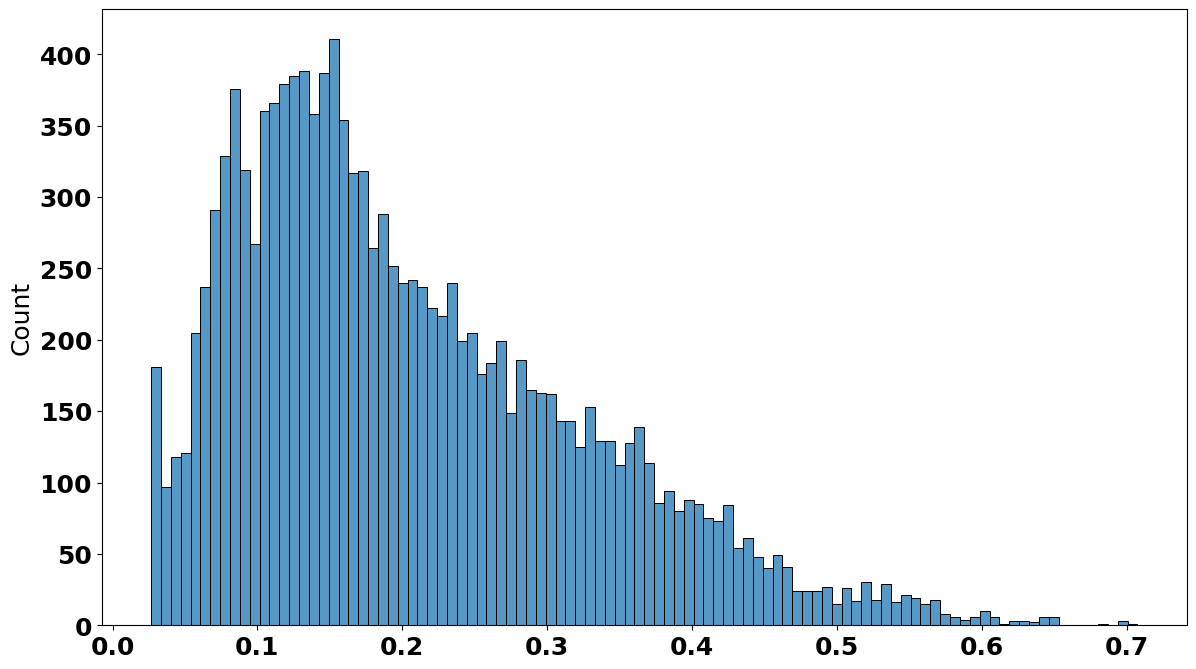

In [ ]:
sns.histplot(
    test_final_preds,
    bins=100
)

In [ ]:
sample_submit = deepcopy(pd.read_csv('test2_X.csv')[["contract_id", "report_date"]])

sample_submit["score"] = test_final_preds

print(sample_submit.head(5))

   contract_id report_date     score
0         3029  2023-07-30  0.878217
1         4350  2023-07-30  0.840636
2         1095  2023-07-30  0.891987
3         2634  2023-07-30  0.907559
4         6535  2023-07-30  0.887980


In [ ]:
if USING_COLAB:
  subs_path = "/content/subs"
else:
  subs_path = "subs"

if not os.path.exists(subs_path):
  os.mkdir(subs_path)

sub_name = "sub"
sample_submit.to_csv(f"{subs_path}/{sub_name}.csv", index=False)